# REMEMBER GRADIENT CHECK

In [1]:
import numpy as np
from numpy import random
from sklearn.metrics import precision_score, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import math
from functions_3 import LoadBatch, montage 
from operator import itemgetter
from functions_3 import ComputeGradsNum
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [11]:
def separete_file(filename):
    data = filename[b'data']
    labels = filename[b'labels']
    y=np.array(filename[b'labels'])#(10000,)
    one_hot = np.zeros((len(y), 10), dtype=int)
    one_hot[np.arange(len(y)), y] = 1 #(10000,10)
    
    return np.transpose(y), np.transpose(one_hot), np.transpose(data)


#L1: W(m=number of hidden nodes x d=number of inputs), b = (m x 1)
#Lj: W(m=n-nodes in the previous layer x i=n-nodes in the j-th layer),b = (i x 1)
#L2: W(K=number of classes x i), b = (K x 1)        
def store_parameters(n_layers, layers_size, He = False, batch_norm = False):
    W = []
    B = []
    gammas = []
    betas = []
    for layer in range(n_layers-1):
        if He:
            w = random.randn(layers_size[layer+1],layers_size[layer])*np.sqrt(2/layers_size[layer])
            if batch_norm:
                b = np.zeros((layers_size[layer+1],1))
            else:
                b = random.randn(layers_size[layer+1],1)*np.sqrt(2/layers_size[layer])

        else:
            w = random.normal(0, 0.01, (layers_size[layer+1],layers_size[layer]))
            b = random.normal(0, 0.01, (layers_size[layer+1],1)) 
            
        gammas.append(np.ones((layers_size[layer],1)))        
        betas.append(np.zeros((layers_size[layer],1))) 
            
        W.append(w)
        B.append(b)
        
    return W, B, gammas[1:], betas[1:]


def ComputeAccuracy(X, y, W, b, gamma, beta, mean, var, batch_norm = False, test = False):
    P, _, _, _, _, _ = EvaluateClassifier(X, W, b, gamma, beta, mean, var, batch_norm = batch_norm, test = test)
    estimated_y = np.argmax(P, axis=0)
    accurancy = accuracy_score(y, estimated_y)
    return accurancy


def EvaluateClassifier(X, W, b, gamma, beta, layers_means, layers_var, batch_norm = False, test = False):
    
    k = len(W)
    
    layer_inputs, scores, scores_hat = [X.copy()]+[None]*(k-1), [None]*(k-1), [None]*(k-1)
    if not test:
        layers_means, layers_var = [None]*(k-1), [None]*(k-1)
    
    for layer in range(k-1):
        scores[layer] = (W[layer] @ layer_inputs[layer])+ b[layer]
        if batch_norm:
            if not test:
                layers_means[layer] = scores[layer].mean(axis=1).reshape(-1,1)
                layers_var[layer] = scores[layer].var(axis=1).reshape(-1,1)
            #sHat, l_mean, l_var = normalize(s, 1e-15, mean, var, test, layer)
            scores_hat[layer] = (scores[layer] - layers_means[layer]) / (np.sqrt(layers_var[layer] + 1e-15))
            sTilde = scores_hat[layer] * gamma[layer] + beta[layer]#np.vstack
            sTilde[sTilde < 0] = 0 #ReLu activation function
            X = sTilde
            layer_inputs[layer+1] = X
            
        else:
            X = scores[layer]
            X[X < 0] = 0 #ReLu activation function
            layer_inputs[layer+1] = X   
          
    s_final = W[k-1] @ layer_inputs[k-1] + b[k-1]
    P = np.exp(s_final)/np.sum(np.exp(s_final), axis=0)
    
    return P, scores, scores_hat, layer_inputs[1:], layers_means, layers_var


def ComputeCost(X, Y, W, b, gamma, beta, lambd, mean, var, batch_norm = False, test = False):
    P, _, _, _, _, _  = EvaluateClassifier(X, W, b, gamma, beta, mean, var, batch_norm = batch_norm, test = test)
    Ws_sum_square = [np.sum(np.square(x)) for x in W]
    regulaizer = lambd*(sum(Ws_sum_square))
    N = X.shape[1]
    square_matrix = np.multiply(Y, np.log(P))
    sum_diag = -np.sum(square_matrix) 
    cost = (1/N) * sum_diag + regulaizer
    return cost

def ComputeGradients(X, Y, W, b, gamma, beta, lambd, batch_norm = False):
    P, scores, scores_hat, layer_inputs, l_means, l_var=EvaluateClassifier(X, W, b, gamma, beta, None, None, 
                                                                           batch_norm=batch_norm, test=False)
    #stop stop stop stop stop stop stop stop
    N = X.shape[1]
    k = len(W)
    gradients_W, gradients_b = [None]*k, [None]*k
    gradients_gamma, gradients_beta = [None]*(k-1), [None]*(k-1)
    
    if batch_norm:
        layer_inputs = [X.copy()] + layer_inputs
    else:
        layer_inputs = [X.copy()] + scores
    
    G_batch = -(Y - P)
    gradients_W[k-1] = (G_batch @ np.transpose(layer_inputs[k-1])) / N + 2*lambd*W[k-1]
    gradients_b[k-1] = (G_batch @ np.ones((N,1))) / N
    G_batch = np.transpose(W[k-1]) @ G_batch
    G_batch = G_batch * (layer_inputs[k-1]>0)
    
    for layer in range(k-2, -1, -1):

        if batch_norm:
            gradients_gamma[layer] =((G_batch * scores_hat[layer]) @ np.ones((N,1)))/N
            gradients_beta[layer] = (G_batch @ np.ones((N,1)) ) / N
            G_batch_ = G_batch *(gamma[layer] @ np.ones((1, N)) )            
            G_batch = BatchNormBackPass(G_batch_, scores[layer], l_means[layer], l_var[layer])

        gradients_W[layer] = (G_batch @ np.transpose(layer_inputs[layer])) / N + 2*lambd*W[layer]
        gradients_b[layer] = (G_batch @ np.ones((N,1)) ) / N 
        
        if layer > 0:
            G_batch = np.transpose(W[layer]) @ G_batch
            G_batch = G_batch * (layer_inputs[layer]>0)
         
        
    return gradients_W, gradients_b, gradients_gamma, gradients_beta, l_means, l_var 

def BatchNormBackPass(G, S, mean, var):
    n = S.shape[1]
    G1 = G*(((var+1e-15)**(-0.5))@np.ones((1,n)))
    G2 = G*(((var+1e-15)**(-1.5))@np.ones((1,n)))
    D = S-mean@np.ones((1,n))
    c = (G2*D)@np.ones((n,1))
    
    return G1-(G1@np.ones((n,1)))/n-D*(c@np.ones((1,n)))/n

def MiniBatchGD_CLR(X, Y, y, X_val, Y_val, y_val, n_batch, eta, n_epochs, W, b, gamma, beta, lambd, n_s, alpha,
                    CLR_bool=False,batch_norm=False, shuffle=False):
    N = X.shape[1]
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []
    etas = []
    k_list1 = list(range(0, n_s, 1))
    k_list2 = list(range(n_s, 0, -1))
    k_list = np.concatenate([k_list1, k_list2], axis=0)
    cycle_idx = 0
    X_original, Y_original, y_original = X.copy(), Y.copy(), y.copy()
    
    for epoch in range(n_epochs):
    
        for batch in range(0, N, n_batch):    
            gradients_W, gradients_b, gradients_gamma, gradients_beta, l_means, l_var = ComputeGradients(
                                                                                         X[:,batch:batch+n_batch], 
                                                                                         Y[:,batch:batch+n_batch],
                                                                                         W, b, gamma, beta, lambd,
                                                                                         batch_norm = batch_norm)
            if CLR_bool:
                interCounter = k_list[cycle_idx]      
                cycle_idx += 1
                if cycle_idx >= len(k_list):
                    cycle_idx = 0
                eta = CLR(interCounter, 1e-5, 1e-1, n_s)
                etas.append(eta)
                
            W -= eta*np.array(gradients_W)
            b -= eta*np.array(gradients_b)
            
            if batch_norm:              
                gamma -= eta*np.array(gradients_gamma)
                beta -= eta*np.array(gradients_beta)
                if epoch == 0 and batch == 0:
                    means_avg = l_means
                    var_avg = l_var
                else:
                    mean_avg = [alpha*means_avg[l]+(1-alpha)*l_means[l] for l in range(len(l_means))]
                    var_avg = [alpha*var_avg[l]+(1-alpha)*l_var[l] for l in range(len(l_var))]
            else:
                mean_avg, var_avg = None, None
                    
    
      
        train_acc.append(ComputeAccuracy(X, y, W, b, gamma, beta, mean_avg, var_avg, batch_norm = batch_norm, 
                                         test = False))
        train_loss.append(ComputeCost(X, Y, W, b, gamma, beta, lambd, mean_avg, var_avg, batch_norm = batch_norm,
                                         test = False))

        val_acc.append(ComputeAccuracy(X_val, y_val, W, b, gamma, beta, mean_avg, var_avg, batch_norm =batch_norm, 
                                         test = False))
        val_loss.append(ComputeCost(X_val, Y_val, W, b, gamma, beta, lambd, mean_avg, var_avg, batch_norm = batch_norm, 
                                         test = False))
        
        if shuffle:
            np.random.seed(epoch)
            permuted_indexes = np.random.permutation(N)
            X = X_original[:,permuted_indexes]
            Y = Y_original[:,permuted_indexes]
            y = [y_original[index] for index in permuted_indexes]        
        
    return W, b, gamma, beta, train_acc, train_loss, val_acc, val_loss, etas, mean_avg, var_avg


def CLR(iterCounter, eta_min, eta_max, n_s):   
    cycle = math.floor(iterCounter/(2 * n_s)) #current cycle --> current 'trinagle' 
    
    if iterCounter >= 2*n_s*cycle and iterCounter < (2*cycle + 1)*n_s:#if t is located in the first half of the triangle
        eta = eta_min + ((iterCounter - 2*n_s*cycle)*(eta_max - eta_min) / n_s)
        
    elif iterCounter >= (2*cycle + 1)*n_s and iterCounter < 2*(cycle + 1)*n_s:#if t is located in the second half of the triangle
        eta = eta_max - ((iterCounter - (2*cycle+1)*n_s)*(eta_max - eta_min) / n_s)
        
    return eta


def grid_search(X, Y, y, X_val, Y_val, y_val, n_batch, eta, n_epochs, W, b, gamma, beta, lambdas, n_s, alpha):

    grid_search_array = pd.DataFrame({'lambda':[], 'valid_accurancy':[]})
    for lambd in lambdas:

        _, _, _, _,train_acc, train_loss, val_acc, val_loss, _, _, _ =MiniBatchGD_CLR(X, Y, y, X_val, Y_val, y_val,n_batch,
                                                                   eta, n_epochs, W, b, gamma, beta, lambd, n_s,
                                                                   alpha,CLR_bool = True, batch_norm=True, shuffle=True)

        grid_search_array = grid_search_array.append({'lambda':lambd,'valid_accurancy':max(val_acc)}, ignore_index=True)
        
    grid_search_array.sort_values(['valid_accurancy'], inplace=True)
    return grid_search_array


def plot_loss(train_loss, val_loss):
    plt.plot(train_loss, color='red', label='train loss: '+str(round(train_loss[-1], 3)))
    plt.plot(val_loss, color='blue', label='validation loss: '+str(round(val_loss[-1], 3)))
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    #plt.show()
    
def plot_accurancy(train_acc, val_acc):
    plt.plot(train_acc, color='red', label='train accurancy: '+str(round(max(train_acc), 3)))
    plt.plot(val_acc, color='blue', label='validation accurancy: '+str(round(max(val_acc), 3)))
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accurancy")
    #plt.show() 

### Reproduce the results from Assignment2 

#### Use the entire dataset: 45000 train, 5000 validation

In [3]:
batch1 = LoadBatch('data_batch_1')
batch2 = LoadBatch('data_batch_2')
batch3 = LoadBatch('data_batch_3')
batch4 = LoadBatch('data_batch_4')
batch5 = LoadBatch('data_batch_5')
test = LoadBatch('test_batch')

y_train1,one_hot_train1,images_train1=separete_file(batch1)
y_train2,one_hot_train2,images_train2=separete_file(batch2)
y_train3,one_hot_train3,images_train3=separete_file(batch3)
y_train4,one_hot_train4,images_train4=separete_file(batch4)
y_train5,one_hot_train5,images_train5=separete_file(batch5)
y_test,one_hot_test,images_test=separete_file(test)

#Concatenate the five batch files to get the entire dataset
CIFAR10 = np.concatenate((images_train1, images_train2, images_train3, images_train4, images_train5), axis = 1)#3072x50000
LABELS = np.concatenate((y_train1, y_train2, y_train3, y_train4, y_train5), axis = 0)#50000,1
ONE_HOT = np.concatenate((one_hot_train1, one_hot_train2, one_hot_train3, one_hot_train4, one_hot_train5), axis = 1)#10x50000


# Subset the validation set
np.random.seed(0)
indexes_validation = np.random.choice(range(CIFAR10.shape[1]), 5000, replace=False)
CIFAR10_val = CIFAR10[:,indexes_validation]
ONE_HOT_val = ONE_HOT[:,indexes_validation]#10x5000
LABELS_val = [LABELS[i] for i in indexes_validation]#5000x1

# Subset the training set
CIFAR10_train = np.delete(CIFAR10, indexes_validation, 1)
ONE_HOT_train = np.delete(ONE_HOT, indexes_validation, 1)#10x45000
LABELS_TRAIN = [LABELS[i] for i in range(CIFAR10.shape[1]) if i not in indexes_validation]#45000x1

#Normalize the train, val, and test data with the train's means and standard deviations
column_means = np.vstack(CIFAR10_train.mean(axis=1))#train's means
column_stds = np.vstack(CIFAR10_train.std(axis=1))#train's stds
CIFAR10_train_norm = (CIFAR10_train - column_means) / column_stds#3072x45000
CIFAR10_val_norm = (CIFAR10_val-column_means) / column_stds
CIFAR10_test_norm = (images_test-column_means) / column_stds#3072x10000

#### Train a 3-layer network with 50 and 50 nodes hidden layers, two cycles.

Text(0, 0.5, 'Accurancy')

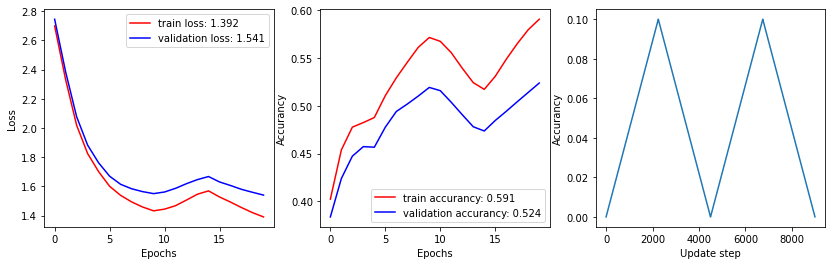

In [44]:
L1 = 50                            #number of hidden nodes in the first hidden layer
L2 = 50                            #number of hidden nodes in the second hidden layer
d = images_train_norm.shape[0]     #number of input nodes
K = one_hot_train.shape[0]         #number of classes

W, b, gamma, beta = store_parameters(4, [d,L1,L2,K], He = True, batch_norm=False)
n_s = int((5*45000)/100)

W_, b_, gamma_, beta_, train_acc, train_loss, valid_acc, valid_loss, etas,_,_ = MiniBatchGD_CLR(CIFAR10_train_norm, ONE_HOT_train, 
                                                                            LABELS_TRAIN, CIFAR10_val_norm, ONE_HOT_val,
                                                                            LABELS_val,n_batch = 100, eta = None, 
                                                                            n_epochs = 20, W=W, b=b, gamma=gamma,
                                                                            beta=beta,lambd= 0.005, 
                                                                            n_s=n_s, alpha=None,
                                                                            CLR_bool=True, batch_norm=False,
                                                                            shuffle = False)

fig = plt.figure(figsize=(14,4))
fig.add_subplot(131)
plot_loss(train_loss, valid_loss)
fig.add_subplot(132)
plot_accurancy(train_acc, valid_acc)
fig.add_subplot(133)
plt.plot(etas)
plt.xlabel('Update step')
plt.ylabel('Accurancy')

#### Train a 9-layer network with  [50, 30, 20, 20, 10, 10, 10, 10] nodes hidden layers, two cycles. Same Hyperparameters as before.

Text(0, 0.5, 'Accurancy')

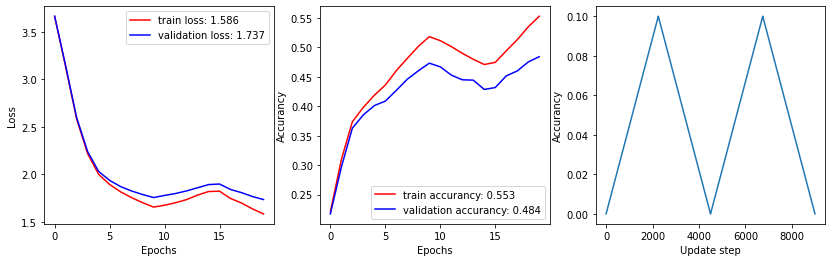

In [11]:
L1 = 50                            #number of hidden nodes in the first hidden layer
L2 = 30                            #number of hidden nodes in the second hidden layer
L3 = 20                            #number of hidden nodes in the second hidden layer
L4 = 20                            #number of hidden nodes in the second hidden layer
L5 = 10                            #number of hidden nodes in the second hidden layer
L6 = 10                            #number of hidden nodes in the second hidden layer
L7 = 10                            #number of hidden nodes in the second hidden layer
L8 = 10                            #number of hidden nodes in the second hidden layer

d = CIFAR10_train_norm.shape[0]     #number of input nodes
K = ONE_HOT_train.shape[0]         #number of classes

W, b, gamma, beta= store_parameters(10, [d,L1,L2,L3,L4,L5,L6,L7,L8,K], He = True, batch_norm=False)
n_s = int((5*45000)/100)

W_, b_, gamma_, beta_, train_acc, train_loss, valid_acc, valid_loss, etas,_,_ = MiniBatchGD_CLR(CIFAR10_train_norm, ONE_HOT_train, 
                                                                            LABELS_TRAIN, CIFAR10_val_norm, ONE_HOT_val,
                                                                            LABELS_val,n_batch = 100, eta = None, 
                                                                            n_epochs = 20, W=W, b=b, gamma=gamma,
                                                                            beta=beta,lambd= 0.005, 
                                                                            n_s=n_s, alpha = None,
                                                                            CLR_bool=True, batch_norm=False,
                                                                            shuffle=False)

fig = plt.figure(figsize=(14,4))
fig.add_subplot(131)
plot_loss(train_loss, valid_loss)
fig.add_subplot(132)
plot_accurancy(train_acc, valid_acc)
fig.add_subplot(133)
plt.plot(etas)
plt.xlabel('Update step')
plt.ylabel('Accurancy')

## Batch Normalization

#### 3 layer Network trained for 2 cycles, with Batch Norm

Text(0, 0.5, 'Accurancy')

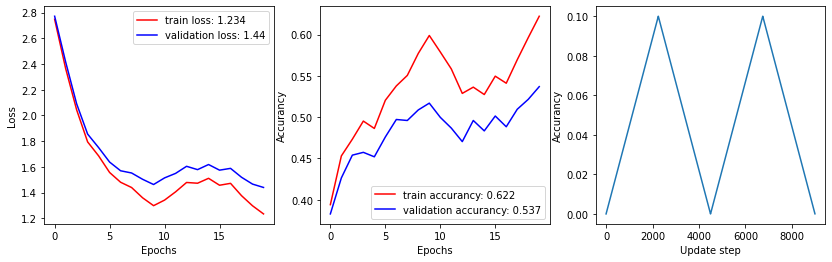

In [63]:
L1 = 50                            #number of hidden nodes in the first hidden layer
L2 = 50                            #number of hidden nodes in the second hidden layer                           #number of hidden nodes in the second hidden layer

d = CIFAR10_train_norm.shape[0]     #number of input nodes
K = ONE_HOT_train.shape[0]         #number of classes
W, b, gamma, beta= store_parameters(4, [d,L1,L2,K], He = True, batch_norm=False)
n_s = int((5*45000)/100)

W_, b_, gamma_, beta_, train_acc, train_loss, valid_acc, valid_loss, etas,_,_ = MiniBatchGD_CLR(CIFAR10_train_norm, ONE_HOT_train, 
                                                                            LABELS_TRAIN, CIFAR10_val_norm, ONE_HOT_val,
                                                                            LABELS_val,n_batch = 100, eta = None, 
                                                                            n_epochs = 20, W=W, b=b, gamma=gamma,
                                                                            beta=beta, lambd= 0.005, 
                                                                            n_s=n_s, alpha = 0.9,
                                                                            CLR_bool=True, batch_norm=True, 
                                                                            shuffle = True)

fig = plt.figure(figsize=(14,4))
fig.add_subplot(131)
plot_loss(train_loss, valid_loss)
fig.add_subplot(132)
plot_accurancy(train_acc, valid_acc)
fig.add_subplot(133)
plt.plot(etas)
plt.xlabel('Update step')
plt.ylabel('Accurancy')

#### Find a good lambda on a broad range of values.

In [64]:
L1 = 50                            #number of hidden nodes in the first hidden layer
L2 = 50                            #number of hidden nodes in the second hidden layer                           #number of hidden nodes in the second hidden layer

d = CIFAR10_train_norm.shape[0]    #number of input nodes
K = ONE_HOT_train.shape[0]         #number of classes
W, b, gamma, beta= store_parameters(4, [d,L1,L2,K], He = True, batch_norm=False)
n_s = int((5*45000)/100)

np.random.seed(0)
l_max, l_min = -1, -5
l = l_min+(l_max-l_min)*np.random.rand(10)
list_lambdas_coarse = list(10**l)
list_lambdas_coarse.sort()

grid_array = grid_search(CIFAR10_train_norm, ONE_HOT_train,LABELS_TRAIN, CIFAR10_val_norm, ONE_HOT_val,LABELS_val, 
                         n_batch=100, eta=None, n_epochs=30, W=W, b=b, gamma=gamma, beta=beta, 
                         lambdas=list_lambdas_coarse, n_s=n_s, alpha = 0.9)
grid_array

,lambda,valid_accurancy
9,0.071557,0.4972
8,0.036906,0.5062
1,0.000495,0.5216
0,0.000342,0.5260
2,0.000563,0.5270
4,0.001568,0.5274
5,0.002577,0.5332
3,0.001512,0.5362
6,0.003833,0.5362
7,0.007257,0.5364


#### Find a good lambda on a stricted range of values.

In [65]:
L1 = 50                            #number of hidden nodes in the first hidden layer
L2 = 50                            #number of hidden nodes in the second hidden layer                           #number of hidden nodes in the second hidden layer

d = CIFAR10_train_norm.shape[0]    #number of input nodes
K = ONE_HOT_train.shape[0]         #number of classes
W, b, gamma, beta= store_parameters(4, [d,L1,L2,K], He = True, batch_norm=False)
n_s = int((5*45000)/100)

list_lambdas_coarse = [0.0015, 0.004, 0.005,0.006, 0.007, 0.0075]

grid_array = grid_search(CIFAR10_train_norm, ONE_HOT_train,LABELS_TRAIN, CIFAR10_val_norm, ONE_HOT_val,LABELS_val, 
                         n_batch=100, eta=None, n_epochs=30, W=W, b=b, gamma=gamma, beta=beta, 
                         lambdas=list_lambdas_coarse, n_s=n_s, alpha = 0.9)
grid_array

,lambda,valid_accurancy
0,0.0015,0.5336
2,0.0050,0.5336
4,0.0070,0.5336
5,0.0075,0.5354
3,0.0060,0.5392
1,0.0040,0.5414


#### 3 layers, best lambda, batch Norm

Text(0, 0.5, 'Accurancy')

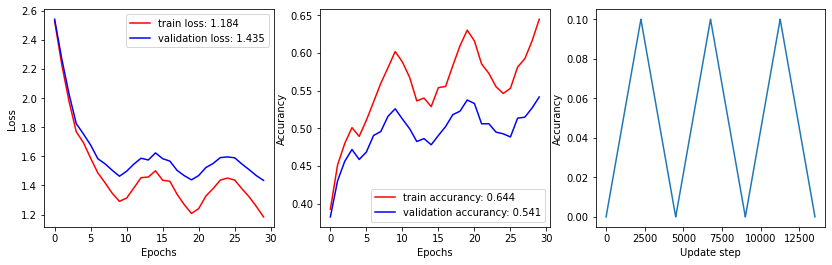

In [71]:
L1 = 50                            #number of hidden nodes in the first hidden layer
L2 = 50                            #number of hidden nodes in the second hidden layer


d = CIFAR10_train_norm.shape[0]     #number of input nodes
K = ONE_HOT_train.shape[0]         #number of classes

W, b, gamma, beta= store_parameters(4, [d,L1,L2,K], He = True, batch_norm=False)
n_s = int((5*45000)/100)

W_, b_, gamma_, beta_, train_acc, train_loss, valid_acc, valid_loss, etas, mean_avg, var_avg = MiniBatchGD_CLR(
                                                                            CIFAR10_train_norm, ONE_HOT_train, 
                                                                            LABELS_TRAIN, CIFAR10_val_norm, ONE_HOT_val,
                                                                            LABELS_val,n_batch = 100, eta = None, 
                                                                            n_epochs = 30, W=W, b=b, gamma=gamma,
                                                                            beta=beta,lambd= 0.004, 
                                                                            n_s=n_s, alpha = 0.9,
                                                                            CLR_bool=True, batch_norm=True,
                                                                            shuffle=True)

fig = plt.figure(figsize=(14,4))
fig.add_subplot(131)
plot_loss(train_loss, valid_loss)
fig.add_subplot(132)
plot_accurancy(train_acc, valid_acc)
fig.add_subplot(133)
plt.plot(etas)
plt.xlabel('Update step')
plt.ylabel('Accurancy')

In [73]:
test_data = CIFAR10_test_norm
test_labels = test[b'labels']
ComputeAccuracy(test_data, test_labels, W_, b_, gamma_, beta_, mean_avg, var_avg, batch_norm = True, test = False)

0.5358

#### 9 layers, best lambda, batch Norm


Text(0, 0.5, 'Accurancy')

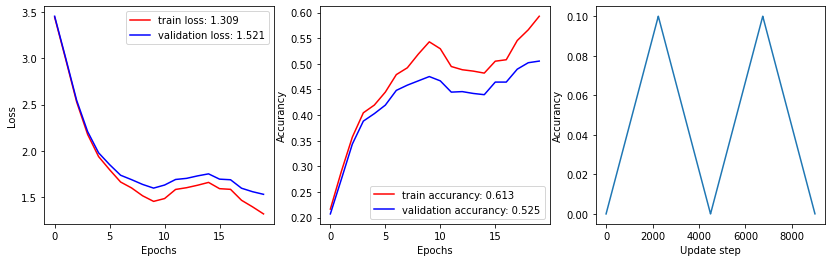

In [13]:
L1 = 50                            #number of hidden nodes in the first hidden layer
L2 = 30                            #number of hidden nodes in the second hidden layer
L3 = 20                            #number of hidden nodes in the second hidden layer
L4 = 20                            #number of hidden nodes in the second hidden layer
L5 = 10                            #number of hidden nodes in the second hidden layer
L6 = 10                            #number of hidden nodes in the second hidden layer
L7 = 10                            #number of hidden nodes in the second hidden layer
L8 = 10                            #number of hidden nodes in the second hidden layer

d = CIFAR10_train_norm.shape[0]     #number of input nodes
K = ONE_HOT_train.shape[0]         #number of classes

W, b, gamma, beta= store_parameters(10, [d,L1,L2,L3,L4,L5,L6,L7,L8,K], He = True, batch_norm=False)
n_s = int((5*45000)/100)

W_, b_, gamma_, beta_, train_acc, train_loss, valid_acc, valid_loss, etas,_,_= MiniBatchGD_CLR(CIFAR10_train_norm, ONE_HOT_train, 
                                                                            LABELS_TRAIN, CIFAR10_val_norm, ONE_HOT_val,
                                                                            LABELS_val,n_batch = 100, eta = None, 
                                                                            n_epochs = 20, W=W, b=b, gamma=gamma,
                                                                            beta=beta,lambd= 0.004, 
                                                                            n_s=n_s, alpha = 0.9,
                                                                            CLR_bool=True, batch_norm=True,
                                                                            shuffle=True)

fig = plt.figure(figsize=(14,4))
fig.add_subplot(131)
plot_loss(train_loss, valid_loss)
fig.add_subplot(132)
plot_accurancy(train_acc, valid_acc)
fig.add_subplot(133)
plt.plot(etas)
plt.xlabel('Update step')
plt.ylabel('Accurancy')

#### Sensitivity to Initialization

In [4]:
def init_parameters(n_layers, layers_size, sigma):
    W = []
    B = []
    gammas = []
    betas = []
    for layer in range(n_layers-1):
        w = random.normal(0, sigma, (layers_size[layer+1],layers_size[layer]))
        b = random.normal(0, sigma, (layers_size[layer+1],1)) 
            
        gammas.append(random.normal(0, sigma, (layers_size[layer],1)))        
        betas.append(random.normal(0, sigma, (layers_size[layer],1))) 
            
        W.append(w)
        B.append(b)
        
    return W, B, gammas[1:], betas[1:]


L1 = 50                            #number of hidden nodes in the first hidden layer
L2 = 50                            #number of hidden nodes in the second hidden layer
d = CIFAR10_train_norm.shape[0]     #number of input nodes
K = ONE_HOT_train.shape[0]         #number of classes
W, b, gamma, beta = init_parameters(4, [3072,50,50,10], 1e-1)
n_s = int((2*45000)/100)

W_, b_, gamma_, beta_, train_acc, train_loss, valid_acc, valid_loss, etas,_,_= MiniBatchGD_CLR(
                                                                            CIFAR10_train_norm, ONE_HOT_train, 
                                                                            LABELS_TRAIN, CIFAR10_val_norm, ONE_HOT_val,
                                                                            LABELS_val,n_batch = 100, eta = None, 
                                                                            n_epochs = 8, W=W, b=b, gamma=gamma,
                                                                            beta=beta,lambd= 0.004, 
                                                                            n_s=n_s, alpha = 0.9,
                                                                            CLR_bool=True, batch_norm=True,
                                                                            shuffle=True)

W_1, b_1, gamma_1, beta_1, train_acc1, train_loss1, valid_acc1, valid_loss1, etas1,_,_= MiniBatchGD_CLR(
                                                                            CIFAR10_train_norm, ONE_HOT_train, 
                                                                            LABELS_TRAIN, CIFAR10_val_norm, ONE_HOT_val,
                                                                            LABELS_val,n_batch = 100, eta = None, 
                                                                            n_epochs = 8, W=W, b=b, gamma=gamma,
                                                                            beta=beta,lambd= 0.004, 
                                                                            n_s=n_s, alpha = 0.9,
                                                                            CLR_bool=True, batch_norm=False,
                                                                            shuffle=False)

In [5]:
L1 = 50                            #number of hidden nodes in the first hidden layer
L2 = 50                            #number of hidden nodes in the second hidden layer
d = CIFAR10_train_norm.shape[0]     #number of input nodes
K = ONE_HOT_train.shape[0]         #number of classes
W, b, gamma, beta = init_parameters(4, [3072,50,50,10], 1e-3)
n_s = int((2*45000)/100)

W_2, b_2, gamma_2, beta_2, train_acc2, train_loss2, valid_acc2, valid_loss2, etas2,_,_= MiniBatchGD_CLR(
                                                                            CIFAR10_train_norm, ONE_HOT_train, 
                                                                            LABELS_TRAIN, CIFAR10_val_norm, ONE_HOT_val,
                                                                            LABELS_val,n_batch = 100, eta = None, 
                                                                            n_epochs = 8, W=W, b=b, gamma=gamma,
                                                                            beta=beta,lambd= 0.004, 
                                                                            n_s=n_s, alpha = 0.9,
                                                                            CLR_bool=True, batch_norm=True,
                                                                            shuffle=True)

W_3, b_13, gamma_3, beta_, train_acc3, train_loss3, valid_acc3, valid_loss3, etas3,_,_= MiniBatchGD_CLR(
                                                                            CIFAR10_train_norm, ONE_HOT_train, 
                                                                            LABELS_TRAIN, CIFAR10_val_norm, ONE_HOT_val,
                                                                            LABELS_val,n_batch = 100, eta = None, 
                                                                            n_epochs = 8, W=W, b=b, gamma=gamma,
                                                                            beta=beta,lambd= 0.004, 
                                                                            n_s=n_s, alpha = 0.9,
                                                                            CLR_bool=True, batch_norm=False,
                                                                            shuffle=False)


In [6]:
L1 = 50                            #number of hidden nodes in the first hidden layer
L2 = 50                            #number of hidden nodes in the second hidden layer
d = CIFAR10_train_norm.shape[0]     #number of input nodes
K = ONE_HOT_train.shape[0]         #number of classes
W, b, gamma, beta = init_parameters(4, [3072,50,50,10], 1e-4)
n_s = int((2*45000)/100)

W_4, b_4, gamma_4, beta_4, train_acc4, train_loss4, valid_acc4, valid_loss4, etas4,_,_= MiniBatchGD_CLR(
                                                                            CIFAR10_train_norm, ONE_HOT_train, 
                                                                            LABELS_TRAIN, CIFAR10_val_norm, ONE_HOT_val,
                                                                            LABELS_val,n_batch = 100, eta = None, 
                                                                            n_epochs = 8, W=W, b=b, gamma=gamma,
                                                                            beta=beta,lambd= 0.004, 
                                                                            n_s=n_s, alpha = 0.9,
                                                                            CLR_bool=True, batch_norm=True,
                                                                            shuffle=True)

W_5, b_5, gamma_5, beta_5, train_acc5, train_loss5, valid_acc5, valid_loss5, etas5,_,_= MiniBatchGD_CLR(
                                                                            CIFAR10_train_norm, ONE_HOT_train, 
                                                                            LABELS_TRAIN, CIFAR10_val_norm, ONE_HOT_val,
                                                                            LABELS_val,n_batch = 100, eta = None, 
                                                                            n_epochs = 8, W=W, b=b, gamma=gamma,
                                                                            beta=beta,lambd= 0.004, 
                                                                            n_s=n_s, alpha = 0.9,
                                                                            CLR_bool=True, batch_norm=False,
                                                                            shuffle=False)


In [8]:
print('with eta = 1e-1 and with batch normalization, the loss is equal to: ', valid_loss[-1] )
print('with eta = 1e-1 and without batch normalization, the loss is equal to: ', valid_loss1[-1] )
print('with eta = 1e-3 and with batch normalization, the loss is equal to: ', valid_loss2[-1] )
print('with eta = 1e-3 and without batch normalization, the loss is equal to: ', valid_loss3[-1] )
print('with eta = 1e-4 and with batch normalization, the loss is equal to: ', valid_loss4[-1] )
print('with eta = 1e-4 and without batch normalization, the loss is equal to: ', valid_loss5[-1] )

with eta = 1e-1 and with batch normalization, the loss is equal to:  1.8552084134923323
with eta = 1e-1 and without batch normalization, the loss is equal to:  1.8876362143131356
with eta = 1e-3 and with batch normalization, the loss is equal to:  1.5432658985326413
with eta = 1e-3 and without batch normalization, the loss is equal to:  2.206405923164953
with eta = 1e-4 and with batch normalization, the loss is equal to:  1.5469789176721254
with eta = 1e-4 and without batch normalization, the loss is equal to:  2.3028124107654597
